# Annotating Continuous Data for Machine Learning

This notebook describes adding annotations to a `mne.io.Raw` object, and how annotations are used in later stages of data processing to assemble a tabulated data for machine learning model building for classification and regression works.

`MNE-sample-data` used are cropped to 60 seconds before loading it into RAM to save memory.

In [1]:
import sys
import os
import numpy as np
import os.path as op
sys.path.append("../")
from mne_path import PathHandler
from glob import glob
ph = PathHandler()

from datetime import timedelta
import mne

%matplotlib inline

In [2]:
# SAMPLE_DATA_DIR = os.path.join(os.environ["HOME"],"mne_data","MNE-sample-data")
SAMPLE_DATA_DIR = ph.cddir(ph.SAMPLE_DIR)

Changed to:  /Users/jonghang/mne_data/MNE-sample-data


In [3]:
sample_data_raw_file = os.path.join(SAMPLE_DATA_DIR, 'MEG', 'sample',
                                    'sample_audvis_raw.fif')
raw = mne.io.read_raw_fif(sample_data_raw_file, verbose=False)
raw.crop(tmax=60).load_data()

Reading 0 ... 36037  =      0.000 ...    60.000 secs...


<Raw | sample_audvis_raw.fif, 376 x 36038 (60.0 s), ~106.6 MB, data loaded>

# Annotations using MNE

* `mne.Annotations` in MNE-Python are a way of storing short strings of information about temporal spans of a `mne.io.Raw` object
* Below the surface, `mne.Annotations` are `list-like <list>` objects, where each element comprises three pieces of information: 
  - __`onset`__ time (in seconds)
  - `duration` (also in seconds), and a 
  - `description` (a text string)
  
Additionally, the `mne.Annotations` object itself also keeps track of `orig_time`, which is a __`POSIX timestamp` denoting a real-world time relative to which the annotation onsets should be interpreted__. 

## Creating annotations programmatically

If you know in advance what spans of the `~mne.io.Raw` object you want
to annotate, `~mne.Annotations` can be created programmatically, and
you can even pass lists or arrays to the `~mne.Annotations`
constructor to annotate multiple spans at once:

In [4]:
my_annot = mne.Annotations(onset=[3, 5, 7],  # in seconds
                           duration=[1, 0.5, 0.25],  # in seconds
                           description=['EVT_A', 'EVT_B', 'EVT_C'])
print(my_annot)

<Annotations | 3 segments: EVT_A (1), EVT_B (1), EVT_C (1)>


Notice that `orig_time` is `None`, because we haven't specified it. In those cases, when you add the annotations to a `mne.io.Raw` object, it is assumed that the `orig_time` matches the time of the first sample of the recording, so `orig_time` will be set to match the recording measurement date (`raw.info['meas_date']`).



In [5]:
raw.set_annotations(my_annot)
print(raw.annotations)

<Annotations | 3 segments: EVT_A (1), EVT_B (1), EVT_C (1)>


Convert meas_date (a tuple of seconds, microseconds) into a float:

In [6]:
meas_date = raw.info['meas_date']
orig_time = raw.annotations.orig_time
print(meas_date == orig_time)

True


The example data used in this notebook is from a __Neuromag System__. It starts counting sample numbers before the recording begins, adding ``my_annot`` to the `mne.io.Raw` object also involved another automatic change: an offset equalling the time of the first recorded sample as follow:

(`raw.first_samp / raw.info['sfreq']`) was added to the ``onset`` values of each annotation (see `time-as-index` for more info on ``raw.first_samp``):

In [7]:
time_of_first_sample = raw.first_samp / raw.info['sfreq']

print(my_annot.onset + time_of_first_sample)
print(raw.annotations.onset)

[45.95597083 47.95597083 49.95597083]
[45.95597083 47.95597083 49.95597083]


* It is possible that the annotation onsets are relative to some other time, you can set `orig_time` can be set before calling `mne.io.Raw.set_annotations`, and the onset times will get adjusted based on the time difference between your specified `orig_time` and `raw.info['meas_date']`
* Without the additional adjustment for `raw.first_samp`. `orig_time` can be specified in various ways, see the [documentation of `mne.Annotations`](https://mne.tools/stable/generated/mne.Annotations.html))
* In this example, `ISO 8601` is used to format string, and set to be 50 seconds later than `raw.info['meas_date']`.

In [8]:
time_format = '%Y-%m-%d %H:%M:%S.%f'
new_orig_time = (meas_date + timedelta(seconds=50)).strftime(time_format)
print(new_orig_time)

later_annot = mne.Annotations(onset = [3, 5, 7],
                              duration = [1, 0.5, 0.25],
                              description = ['EVT_D', 'EVT_E', 'EVT_F'],
                              orig_time = new_orig_time)

raw2 = raw.copy().set_annotations(later_annot)
print(later_annot.onset)
print(raw2.annotations.onset)

2002-12-03 19:02:00.720100
[3. 5. 7.]
[53. 55. 57.]


<div class="alert alert-info"><h4>Note</h4><p>If your annotations fall outside the range of data times in the
    `~mne.io.Raw` object, the annotations outside the data range will
    not be added to ``raw.annotations``, and a warning will be issued.</p></div>

The following shows annotations have been added to a `~mne.io.Raw` object:

Using matplotlib as 2D backend.


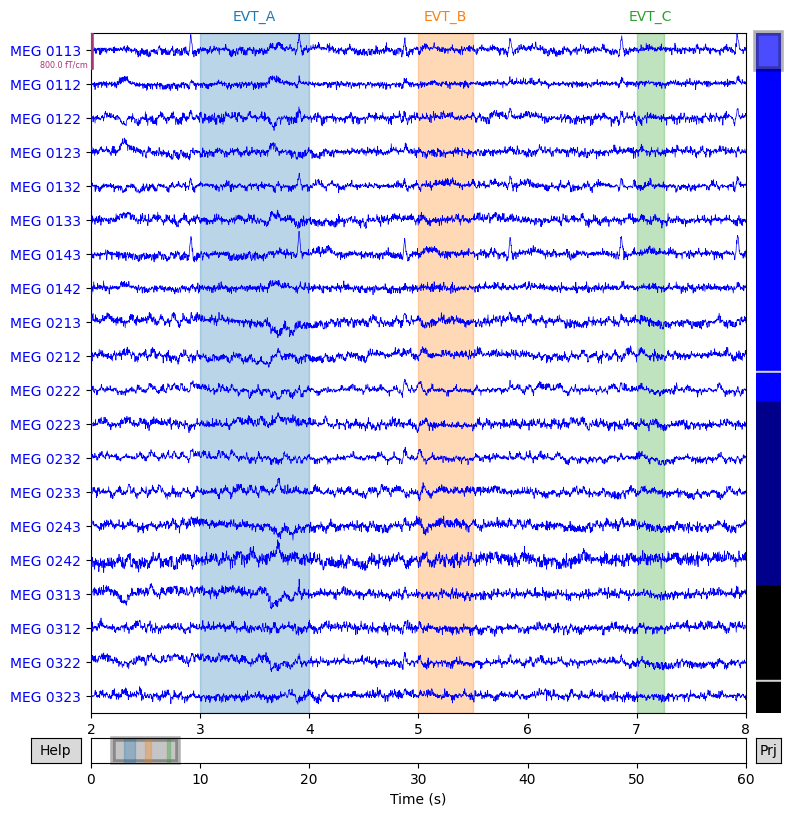

In [9]:
fig = raw.plot(start = 2, duration = 6)

The three annotations appear as differently colored rectangles because they have different ``description`` values (which are printed along the top edge of the plot area). Notice also that colored spans appear in the small scroll bar at the bottom of the plot window, making it easy to quickly view where in a `mne.io.Raw` object the annotations are so you can easily browse through the data to find and examine them.


## Annotating Raw objects interactively

Annotations can also be added to a `mne.io.Raw` object interactively by clicking-and-dragging the mouse in the plot window. To do this, you must first enter "annotation mode" by pressing `a` while the plot window is focused; this will bring up the annotation controls:

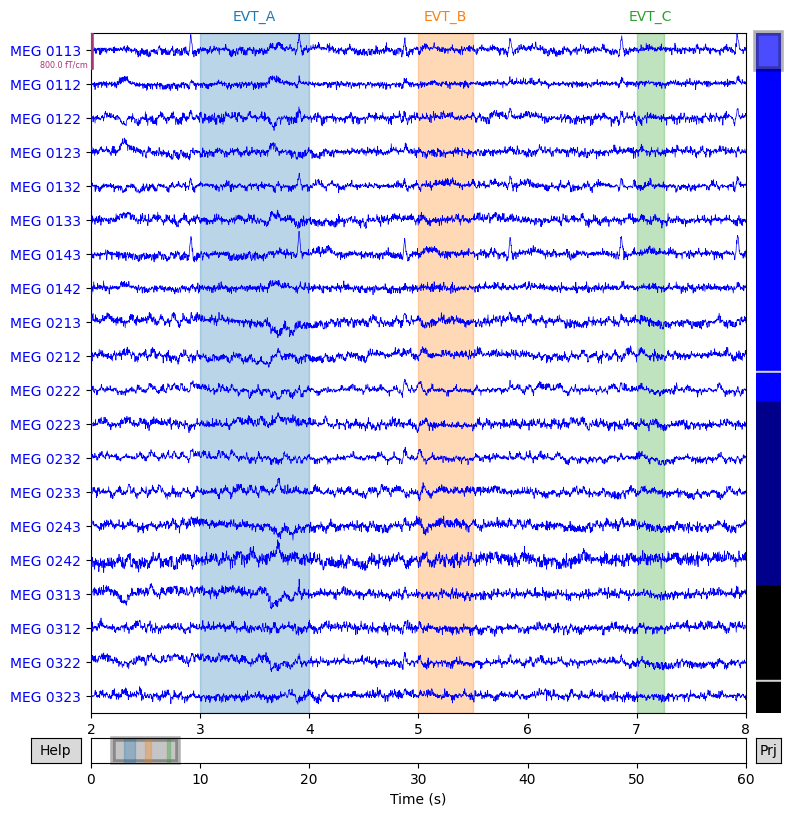

/Users/jonghang/opt/anaconda3/envs/torch311/lib/python3.11/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


In [10]:
fig = raw.plot(start=2, duration=6)
fig.fake_keypress('a')

The drop-down-menu on the left determines which existing label will be
created by the next click-and-drag operation in the main plot window. New
annotation descriptions can be added by clicking the :guilabel:`Add
description` button; the new description will be added to the list of
descriptions and automatically selected.
The following functions relate to which description is currently selected in
the drop-down-menu:
With :guilabel:`Remove description` you can remove description
including the annotations.
With :guilabel:`Edit description` you can edit
the description of either only one annotation (the one currently selected)
or all annotations of a description.
With :guilabel:`Set Visible` you can show or hide descriptions.

During interactive annotation it is also possible to adjust the start and end
times of existing annotations, by clicking-and-dragging on the left or right
edges of the highlighting rectangle corresponding to that annotation. When
an annotation is selected (the background of the label at the bottom changes
to darker) the values for start and stop are visible in two spinboxes and
can also be edited there.

<div class="alert alert-danger"><h4>Warning</h4><p>Calling :meth:`~mne.io.Raw.set_annotations` **replaces** any annotations
    currently stored in the `~mne.io.Raw` object, so be careful when
    working with annotations that were created interactively (you could lose
    a lot of work if you accidentally overwrite your interactive
    annotations). A good safeguard is to run
    ``interactive_annot = raw.annotations`` after you finish an interactive
    annotation session, so that the annotations are stored in a separate
    variable outside the `~mne.io.Raw` object.</p></div>


## How annotations affect preprocessing and analysis

You may have noticed that the description for new labels in the annotation
controls window defaults to ``BAD_``. The reason for this is that annotation
is often used to mark bad temporal spans of data (such as movement artifacts
or environmental interference that cannot be removed in other ways such as
`projection <tut-projectors-background>` or filtering). Several
MNE-Python operations
are "annotation aware" and will avoid using data that is annotated with a
description that begins with "bad" or "BAD"; such operations typically have a
boolean ``reject_by_annotation`` parameter. Examples of such operations are
independent components analysis (`mne.preprocessing.ICA`), functions
for finding heartbeat and blink artifacts
(:func:`~mne.preprocessing.find_ecg_events`,
:func:`~mne.preprocessing.find_eog_events`), and creation of epoched data
from continuous data (`mne.Epochs`). See `tut-reject-data-spans`
for details.


## Operations on Annotations objects

`~mne.Annotations` objects can be combined by simply adding them with
the ``+`` operator, as long as they share the same ``orig_time``:



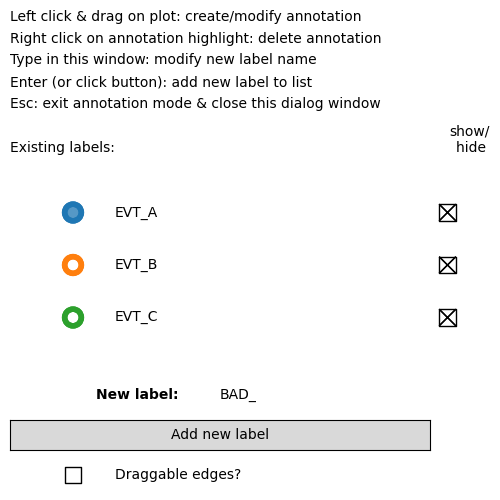

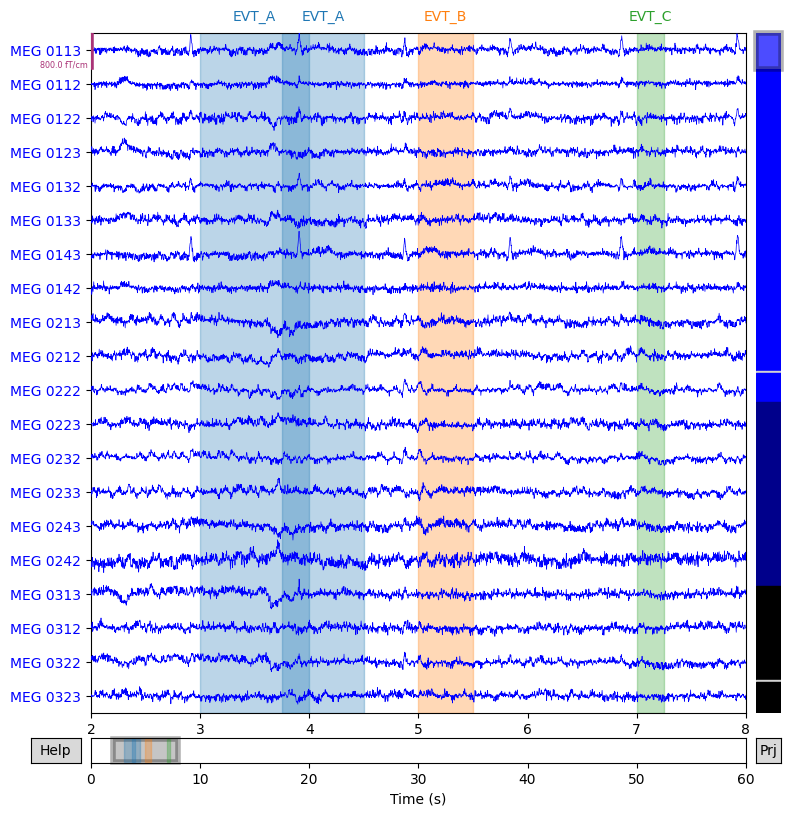

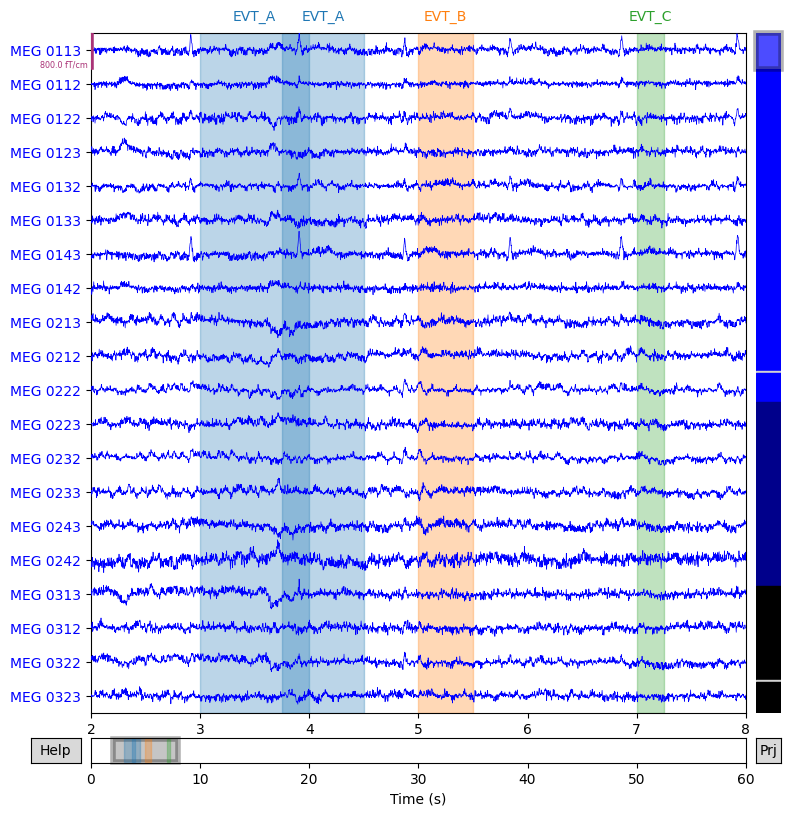

In [11]:
new_annot = mne.Annotations(onset = 3.75, 
                            duration = 0.75, 
                            description='EVT_A')
raw.set_annotations(my_annot + new_annot)
raw.plot(start=2, duration=6)

Notice that it is possible to create overlapping annotations, even when they
share the same description. This is *not* possible when annotating
interactively; click-and-dragging to create a new annotation that overlaps
with an existing annotation with the same description will cause the old and
new annotations to be merged.

Individual annotations can be accessed by indexing an
`~mne.Annotations` object, and subsets of the annotations can be
achieved by either slicing or indexing with a list, tuple, or array of
indices:



In [12]:
print(raw.annotations[0])       # just the first annotation
print(raw.annotations[:2])      # the first two annotations
print(raw.annotations[(3, 2)])  # the fourth and third annotations

OrderedDict([('onset', 45.95597082905339), ('duration', 1.0), ('description', 'EVT_A'), ('orig_time', datetime.datetime(2002, 12, 3, 19, 1, 10, 720100, tzinfo=datetime.timezone.utc))])
<Annotations | 2 segments: EVT_A (2)>
<Annotations | 2 segments: EVT_B (1), EVT_C (1)>


You can also iterate over the annotations within an `~mne.Annotations`
object:



In [13]:
for ann in raw.annotations:
    descr = ann['description']
    start = ann['onset']
    end = ann['onset'] + ann['duration']
    print("'{}' goes from {} to {}".format(descr, start, end))

'EVT_A' goes from 45.95597082905339 to 46.95597082905339
'EVT_A' goes from 46.70597082905339 to 47.45597082905339
'EVT_B' goes from 47.95597082905339 to 48.45597082905339
'EVT_C' goes from 49.95597082905339 to 50.20597082905339


Note that iterating, indexing and slicing `~mne.Annotations` all
return a copy, so changes to an indexed, sliced, or iterated element will not
modify the original `~mne.Annotations` object.



In [14]:
# later_annot WILL be changed, because we're modifying the first element of
# later_annot.onset directly:
later_annot.onset[0] = 99

# later_annot WILL NOT be changed, because later_annot[0] returns a copy
# before the 'onset' field is changed:
later_annot[0]['onset'] = 77

print(later_annot[0]['onset'])

99.0


## Reading and writing Annotations to/from a file

Use the `~mne.Annotations.save` method to write to `.fif`, `.csv`, and :file:`.txt` formats. 

__The format of the onset information that is written to the file depends on the file extension.__ 

While `.csv` files store the onset as timestamps, `.txt` files write floats (in seconds):

In [15]:
raw.annotations.save('saved-annotations.csv', overwrite=True)
annot_from_file = mne.read_annotations('saved-annotations.csv')
print(annot_from_file)

<Annotations | 4 segments: EVT_A (2), EVT_B (1), EVT_C (1)>
